In [12]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.colors as plt_colors
import pathlib
import wget
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import binned_statistic_2d

# Question 1: git in Practice

My GitHub repository can be found here: https://github.com/SeventhofSages/ASTR8004_HW3

Use command line to create a new git repository and README.md file:

```bash
echo "# ASTR8004_HW3" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin git@github.com:SeventhofSages/ASTR8004_HW3.git
git push -u origin main
```

Create a local branch for ASTRO8004 Homework 3 Question 2:

```bash
git checkout -b Q2

```


# Question 2: Using ADQL to Search for Bright Stars Around the Open Cluster M67


#### 2.1 Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)

In [13]:
# Define the center of Messier 67
center = SkyCoord(ra=132.825*u.degree,dec=11.8*u.degree, frame='icrs')

# Define the search radius
radius = 1*u.degree

# ADQL Query for all stars within 1 degree of Messier 67 centre 
# Select * selects all columns
# CONTAINS searches for data points inside a geometric shape
# Crossmatch with star IDs in 2MASS catalogue

query = f"""
SELECT g.*, tmass.*  
FROM gaiadr3.gaia_source AS g
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch
ON g.source_id = xmatch.source_id
JOIN gaiadr1.tmass_original_valid AS tmass
ON xmatch.original_ext_source_id = tmass.designation 
WHERE CONTAINS(
    POINT('ICRS', g.ra, g.dec),
    CIRCLE('ICRS', {center.ra.degree}, {center.dec.degree}, {radius.value})
) = 1
AND phot_g_mean_mag < 14
"""

# Launch the query
job = Gaia.launch_job(query)
results = job.get_results()


#### 2.2 Determine how many stars are returned from the initial query.

In [14]:
# Count the number of stars in query results

print(f'Number of stars returned from query: {len(results)}')

Number of stars returned from query: 1018


In [15]:
results

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,tmass_oid,designation,ra_2,dec_2,err_maj,err_min,err_ang,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ext_key,j_date
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,d
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,fl

In [16]:
# See what columns are in results
results.dtype.names

('solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

Struggled to get np.isnan to pick up the 7 "nan" parallax entries. 

Determined the issue is the arrays were masked arrays, and would disregard "nan" entries for any array calculations. 

Have to use "np.array(results['parallax'].mask)" to ensure python would handle as a normal array and not skip over "nan" entries.

In [17]:
# Double check if any NaN in parallax

# np.savetxt('parallax.csv', results['parallax'], delimiter=',')

x = results['parallax'] == "--"

print(np.sum(x))

y = results['parallax'][104]

print(y)

z = np.isnan(results['parallax'])

print(z)

results['parallax'].mask[103:105]

np.sum(results['parallax'].mask)

np.array(results['parallax'].mask)

0
--
[False False False ... False False False]


array([False, False, False, ..., False, False, False])

#### 2.3 Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.

#### Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

In [18]:
# Identify any stars with bas 2MASS photometry, where ph_qual is not 'AAA'

photo_check = results['ph_qual'] != "AAA" 

print(f'There are {np.sum(photo_check)} stars with bad 2MASS photometry: {results[photo_check]["DESIGNATION"]}')

# Identify any stars with negative (or non-positive) parallaxes in the Gaia data

parallax_check = np.array(results['parallax'] < 0) | np.array(results['parallax'].mask)

print(f'There are {np.sum(parallax_check)} stars with negative/NaN parallax: {results[parallax_check]["DESIGNATION"]}')


There are 21 stars with bad 2MASS photometry:         DESIGNATION        
---------------------------
Gaia DR3 598677041873269888
Gaia DR3 598689102141448320
Gaia DR3 598689102142789760
Gaia DR3 598896841119762816
Gaia DR3 598921030375475072
Gaia DR3 598921030375475200
Gaia DR3 598925943818062208
Gaia DR3 598955115237068032
Gaia DR3 608019317296666624
Gaia DR3 608020176290124544
Gaia DR3 604636321880758144
Gaia DR3 604684326730942592
Gaia DR3 604713459494948352
Gaia DR3 604904847532342272
Gaia DR3 604904847532342528
Gaia DR3 604911268507711232
Gaia DR3 604917831219174528
Gaia DR3 604917835513458688
Gaia DR3 604921202767811712
Gaia DR3 604950271106216064
Gaia DR3 605101037342309376
There are 9 stars with negative/NaN parallax:         DESIGNATION        
---------------------------
Gaia DR3 598847569256078464
Gaia DR3 598873953238690816
Gaia DR3 598886739356653696
Gaia DR3 598892580511613312
Gaia DR3 598892580512198144
Gaia DR3 604917663716360576
Gaia DR3 604918282190043648
Gaia DR3 604

#### 2.4 Apply these two quality cuts (removing stars with bad 2MASS photometry and nonpositive parallaxes). After applying the cuts, determine how many stars remain.

In [19]:
# Combine bad photometric and parallax data masks
bad_in = np.bitwise_or(photo_check, parallax_check)

# Generate array of opposite mask 
good_in = np.where(~bad_in)

# Make new clean results table
clean_results = results[good_in]

print(f'Number of stars returned from query: {len(clean_results)}')

Number of stars returned from query: 988


In [20]:
clean_results

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,tmass_oid,designation,ra_2,dec_2,err_maj,err_min,err_ang,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ext_key,j_date
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,d
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,fl

#### 2.5 Using the remaining stars, generate a figure with two panels (1 point per panel):

#### (a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.

#### (b) A 2MASS J-Ks vs. apparent K magnitude diagram.

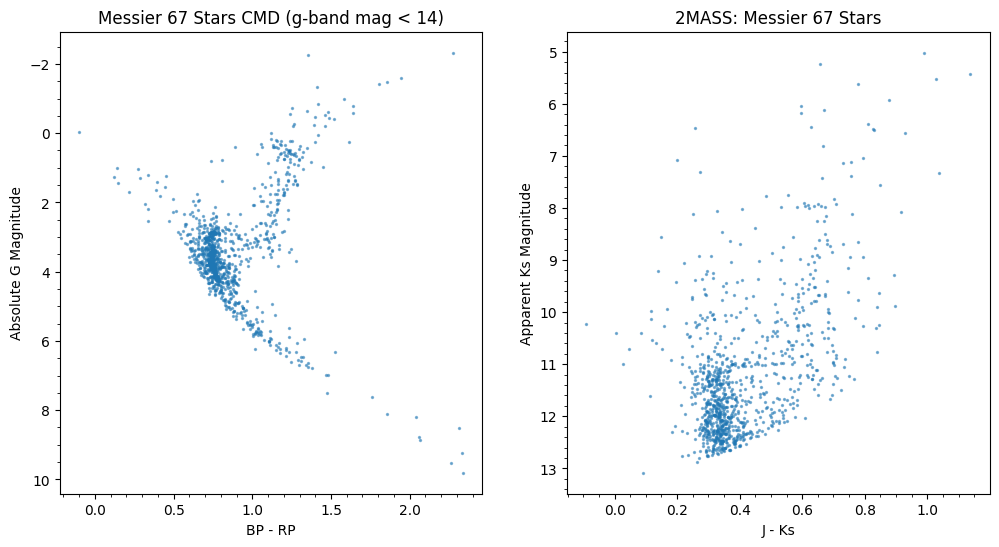

In [21]:
# Calculate absolute G magnitude
abs_g = clean_results['phot_g_mean_mag'] - 5 * np.log10(1000 / clean_results['parallax']) + 5

# Calculate J-Ks 2MASS data
j_ks = clean_results['j_m'] - clean_results['ks_m']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Gaia CMD
ax1.scatter(clean_results['bp_rp'], abs_g, alpha=0.5, s=2)
ax1.set_xlabel('BP - RP')
ax1.set_ylabel('Absolute G Magnitude')
ax1.set_title('Messier 67 Stars CMD (g-band mag < 14)')
ax1.invert_yaxis()
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Plot 2MASS data
ax2.scatter(j_ks, clean_results['ks_m'], alpha=0.5, s=2)
ax2.set_xlabel('J - Ks')
ax2.set_ylabel('Apparent Ks Magnitude')
ax2.set_title('2MASS: Messier 67 Stars')
ax2.invert_yaxis()
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# Adjust layout and display
# plt.tight_layout()
plt.show()

#### 2.6 Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.

In [22]:
# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / 'cmds_M67.png', dpi=200, bbox_inches='tight')


#### 2.7 Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

To my Fellow Colleague, 

Good news! I would recommend proceeding with your observation proposal using the 2dF fibre positioner and HERMES spectrograph for the Messier 67 cluster. My reasoning is as follows:

- I believe there are sufficiently bright enough targets. After analysing all stars within 1 degree of the center of the cluster that are brighter than G=14 (and crossmatching with 2MASS to ensure quality data for accurate analysis), I found 988 appropriate targets for your observation. In checking your proposed instrument (2dF), it appears that there are two field plates that each have 392 fibres, which means 392 spectra can be taken at once. As such, it has been determined that the number of targets is sufficient for this instrument!

- The CDM show a well-defined cluster sequence, which will allow for a comprehensive study of the cluster's stellar population. The CMDs also suggest a variety of stellar types, from main sequence to evolved stars, providing an opportunity to study different evolutionary stages within the cluster. 

I wish you all the best in your scientific endeavours!

Cheers, 

Your Fellow Colleague

# 3 The radial metallicity relation in simulated data

#### 3.1 Download the file from the link above into data/. Load the file with python and then perform the following tasks to create figures that are saved in figures/:

In [23]:
# Create the 'data' directory if it doesn't exist
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

filename = wget.download(r"https://github.com/svenbuder/astr4004_2024_week7/raw/refs/heads/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits", out=str(data_dir))


In [24]:
# Access downloaded file
fits_file = pathlib.Path('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
assert fits_file.exists()

# Open data file
hdu_list = fits.open(fits_file)

# Inspect headers
display(hdu_list.info())
hdu_list[1].header.items

Filename: data\nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   


None

<bound method Header.items of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =               511520 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                    4 / number of columns                              
EXTNAME = '/Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e'
TTYPE1  = 'x       '           / label for column 1                             
TFORM1  = 'E       '           / format for column 1                            
TTYPE2  = 'y       '           / label for column 2                            

#### 3.2 Plot a 2-panel figure:

#### – (a) Logarithmic density plot of RGal. vs. A(O), with a linear fit and legend.

#### – (b) Residuals of the fit, RGal. vs. ΔA(O).

#### Use a python fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include any hyperparameters used.

Calculate the radial position using x,y,z coordinates.

In [25]:
# Dump data into array
data = hdu_list[1].data

# Calculate the radius for each data point
RGal = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

# Extract gas phase metallicity from data
A_O = data["A_O"]



Find the best fit by using scipy.minimise to find the hyperparamters that return the smallest uncertainty. These hyperparamters will then be used in the linear fit.

In [26]:
# Define a linear function
def linear_function(x, a, b):
    return a * x + b

# Define a functions that returns the uncertainty for a given set of hyperparamters
def objective_function(params):
    popt, pcov = curve_fit(linear_function, RGal, A_O, p0=params)
    slope_uncertainty = np.sqrt(np.diag(pcov))[0]
    return slope_uncertainty

# Use scipy.minimize to find the hyperparamters that return the smallest uncertainty
initial_guess = [0, 0]
result = minimize(objective_function, initial_guess, method='Nelder-Mead')
best_hyper_parameters = result.x

print(f"Best Hyperparameters: {best_hyper_parameters}")


Best Hyperparameters: [-6.25e-05  1.25e-04]


Now do the plotting:

Slope: -0.0332502736101902 ± 1.7741308257967144e-05
Intercept: 9.122319363059551 ± 0.0002824670099481285


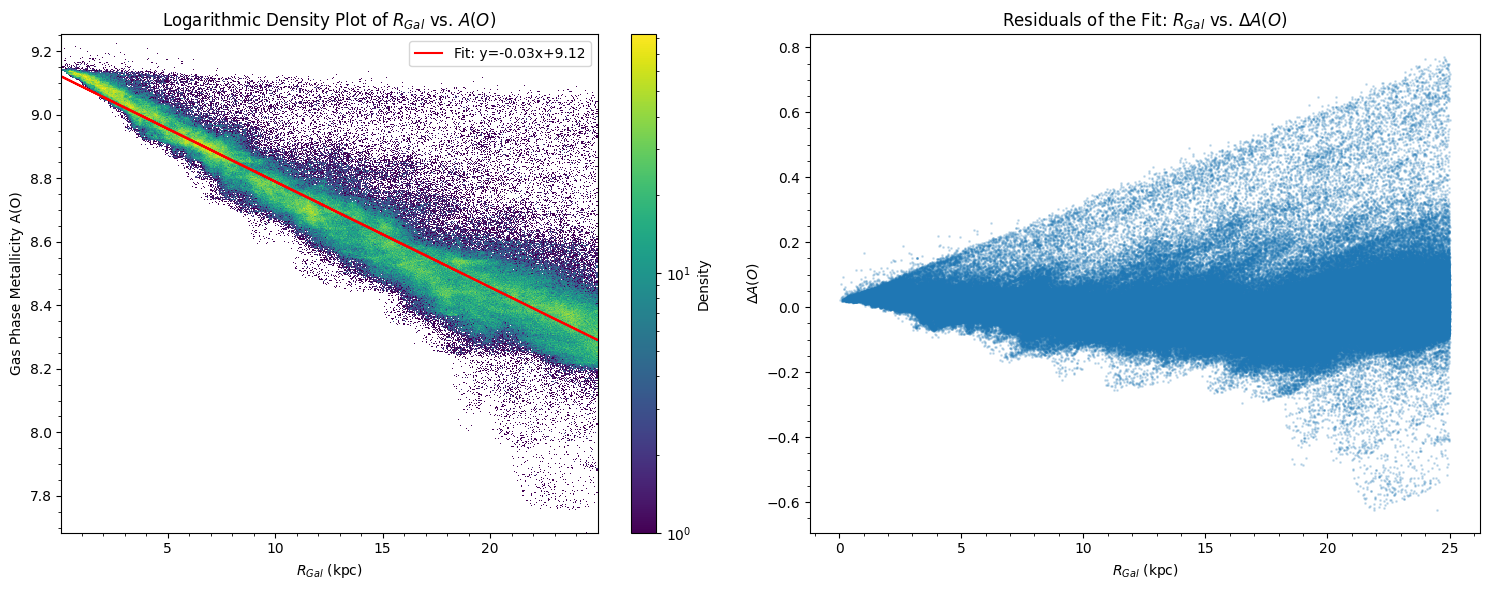

In [27]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


# Create the density plot
hist1 = ax1.hist2d(RGal, A_O, bins=500, cmap='viridis', norm=plt_colors.LogNorm())
fig.colorbar(hist1[3], ax=ax1, label='Density')


# Linear fit
popt, pcov = curve_fit(linear_function, RGal, A_O, p0 = best_hyper_parameters)
slope, intercept = popt
slope_uncertainty, intercept_uncertainty = np.sqrt(np.diag(pcov))
print(f"Slope: {slope} ± {slope_uncertainty}")
print(f"Intercept: {intercept} ± {intercept_uncertainty}")

# Plot the linear fit
ax1.plot(RGal, intercept + slope * RGal, 'r', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add labels and legend
ax1.set_xlabel('$R_{Gal}$ (kpc)')
ax1.set_ylabel('Gas Phase Metallicity A(O)')
ax1.legend()
ax1.set_title('Logarithmic Density Plot of $R_{Gal}$ vs. $A(O)$')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Calculate residuals
residuals = A_O - (slope*RGal + intercept)

# Plot residuals on the second axis
ax2.scatter(RGal, residuals, alpha=0.2, s=1)

# Add labels and title
ax2.set_xlabel('$R_{Gal}$ (kpc)')
ax2.set_ylabel('$\\Delta A(O)$')
ax2.set_title('Residuals of the Fit: $R_{Gal}$ vs. $\\Delta A(O)$')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# Show the plots
plt.tight_layout()
plt.show()

# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / 'LogDensityPlot_Rgal_AO.png', dpi=200, bbox_inches='tight')


#### 3.3 Discuss where the linear model fits well and where it does not. Use statistical metrics, such as the root mean squares or other goodness-of-fit indicators, to quantify the performance of your linear fit in general and regions with larger residuals.

In [28]:
# Calculate Global RMS Error
mse = np.mean(residuals**2)
print(f"Mean Squared Error: {mse}")
rms = np.sqrt(mse) 
print(f"Root Mean Squared Error: {rms}")

# Calculate RMS Error in 0-5 kpc region
residuals_0_5 = residuals[RGal < 5]
mse_0_5 = np.mean(residuals_0_5**2)
print(f"Mean Squared Error (0-5 kpc): {mse_0_5}")
rms_0_5 = np.sqrt(mse_0_5) 
print(f"Root Mean Squared Error (0-5 kpc): {rms_0_5}")

# Calculate RMS Error in 20-25 kpc region
residuals_20_25 = residuals[RGal > 20]
mse_20_25 = np.mean(residuals_20_25**2)
print(f"Mean Squared Error (20-25 kpc): {mse_20_25}")
rms_20_25 = np.sqrt(mse_20_25) 
print(f"Root Mean Squared Error (20-25 kpc): {rms_20_25}")

Mean Squared Error: 0.007670284567290743
Root Mean Squared Error: 0.08758016080877418
Mean Squared Error (0-5 kpc): 0.0013561010771541554
Root Mean Squared Error (0-5 kpc): 0.03682527769283153
Mean Squared Error (20-25 kpc): 0.012900744380803663
Root Mean Squared Error (20-25 kpc): 0.11358144382249974


The overall root mean square error (RMSE) is ~ 0.0876, indicating the average deviation of the data points from the fitted line. At first glance, this seems at odds with the data which shows quite a spread over A(O) values. However, we can see from the density plot that most data points lie close to the fit. A RMSE of 0.0876 indicates the linear model provides a reasonable fit to the overall trend, capturing the general decrease in metallicity A(O) with increasing galactocentric radius RGal.

The fit performs best in the inner regions (0-5 kpc) with the lowest RMSE of ~ 0.0368. This suggests that the linear model is most accurate in describing the metallicity gradient near the galactic center.

In looking at the RMSE for RGal between 20-25 kpc, which has larger residuals, we see that the RMSE increases to ~ 0.1136. This indicates the linear model does not fit the data well in this region.

#### 3.4 Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:

#### – (a) 2D-histogram of the median simulated A(O)

#### – (b) 2D-histogram of the median fitted A(O)

#### – (c) 2D-histogram of the median residuals ΔA(O)

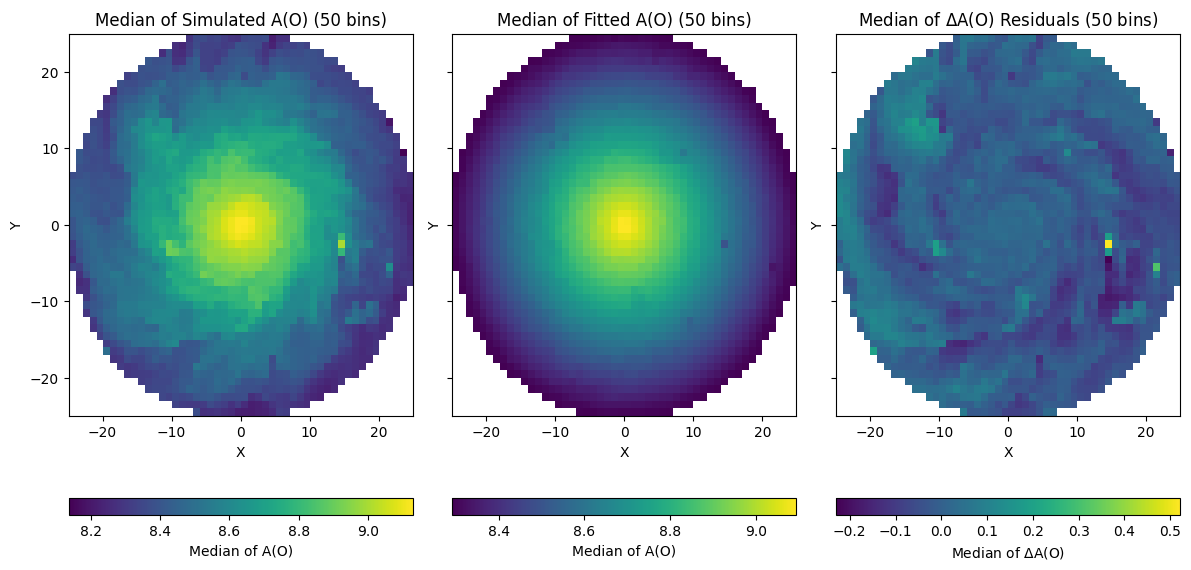

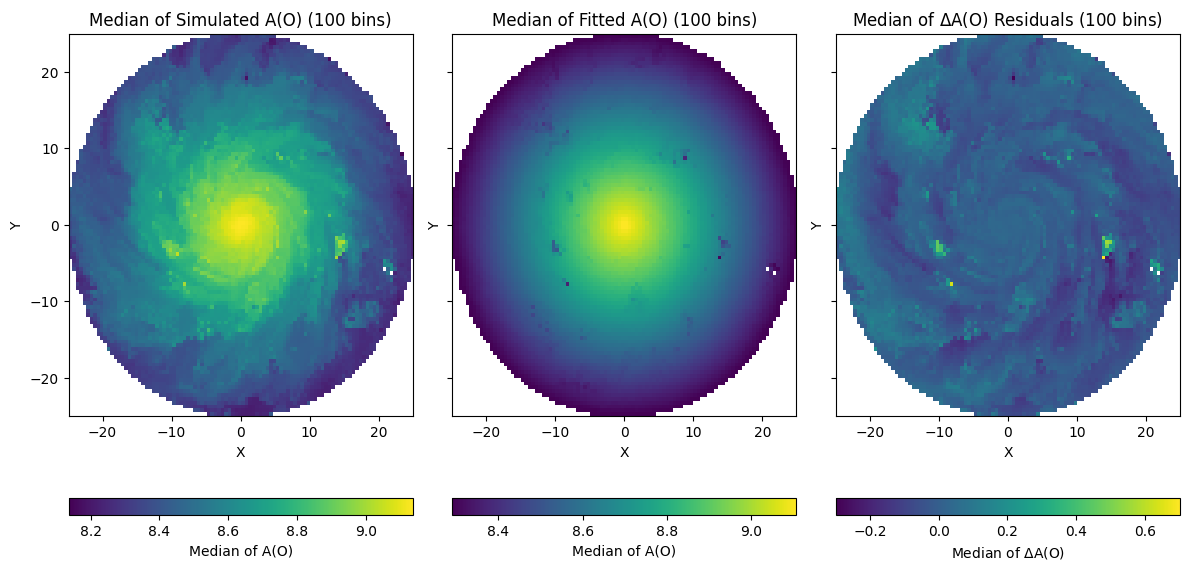

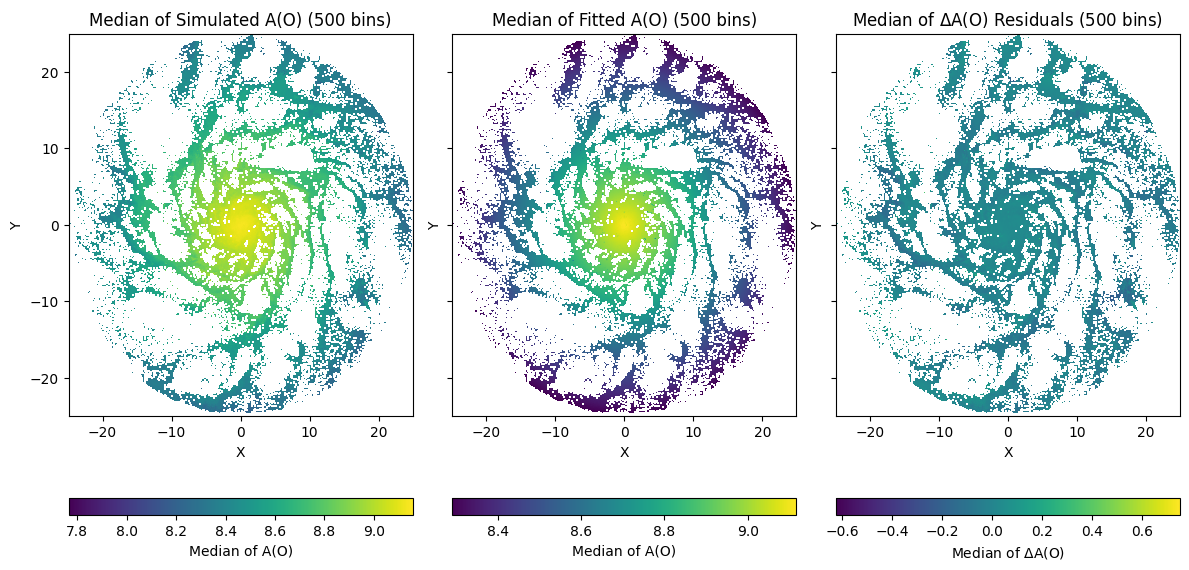

In [29]:
# Assign data from array
x = data["x"]
y = data["y"]
z = data["z"]
A0 = data["A_O"]
A0_interpreted = slope*RGal + intercept

# Define the number of bins
binnybins = 50

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)

# First panel: 2D histogram (binned stats) colored by median
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0, statistic='median', bins=binnybins)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[0].set_title(f"Median of Simulated A(O) ({binnybins} bins)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median for fitted AO
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0_interpreted, statistic='median', bins=binnybins)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[1].set_title(f"Median of Fitted A(O) ({binnybins} bins)")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median of resduals
bin_stat_std, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals, statistic='median', bins=binnybins)
im2 = axs[2].imshow(bin_stat_std.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap='viridis')
axs[2].set_title(f"Median of $\\Delta$A(O) Residuals ({binnybins} bins)")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im2, ax=axs[2], label="Median of $\\Delta$A(O)", orientation='horizontal')

# Show plot
plt.tight_layout()
plt.show()

# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / '2DHistogram_50bins.png', dpi=200, bbox_inches='tight')



# Create figure and subplots for changed bin numbers for comparison
binnybins = 100
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)

# First panel: 2D histogram (binned stats) colored by median
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0, statistic='median', bins=binnybins)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[0].set_title(f"Median of Simulated A(O) ({binnybins} bins)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median for fitted AO
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0_interpreted, statistic='median', bins=binnybins)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[1].set_title(f"Median of Fitted A(O) ({binnybins} bins)")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median of resduals
bin_stat_std, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals, statistic='median', bins=binnybins)
im2 = axs[2].imshow(bin_stat_std.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap='viridis')
axs[2].set_title(f"Median of $\\Delta$A(O) Residuals ({binnybins} bins)")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im2, ax=axs[2], label="Median of $\\Delta$A(O)", orientation='horizontal')

# Show plot
plt.tight_layout()
plt.show()

# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / '2DHistogram_100bins.png', dpi=200, bbox_inches='tight')




# Create figure and subplots for changed bin numbers for comparison
binnybins = 500
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)

# First panel: 2D histogram (binned stats) colored by median
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0, statistic='median', bins=binnybins)
im = axs[0].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[0].set_title(f"Median of Simulated A(O) ({binnybins} bins)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0], label="Median of A(O)", orientation='horizontal')

# Second panel: 2D histogram (binned stats) colored by median for fitted AO
bin_stat_mean, xedges, yedges, binnumber = binned_statistic_2d(x, y, A0_interpreted, statistic='median', bins=binnybins)
im = axs[1].imshow(bin_stat_mean.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
axs[1].set_title(f"Median of Fitted A(O) ({binnybins} bins)")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1], label="Median of A(O)", orientation='horizontal')

# Third panel: 2D histogram (binned stats) colored by median of resduals
bin_stat_std, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals, statistic='median', bins=binnybins)
im2 = axs[2].imshow(bin_stat_std.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap='viridis')
axs[2].set_title(f"Median of $\\Delta$A(O) Residuals ({binnybins} bins)")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
plt.colorbar(im2, ax=axs[2], label="Median of $\\Delta$A(O)", orientation='horizontal')

# Show plot
plt.tight_layout()
plt.show()

# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / '2DHistogram_500bins.png', dpi=200, bbox_inches='tight')

#### 3.5 Describe your choice of 2D bins. Discuss what details would be missed with fewer bins or problems encountered with more bins.

I chose 50 bins, 100 bins, and 500 bins. 

- 50 bins: This choice allows for a decent spatial resolution and you can easily see the large-scale trends in these plots. This choice could miss fine structure due to smoothing over the limited bins. One example of this is that the two empty bins in later plots are not present here, as adjacent positional data was binned into this plot, resulting in a loss of that detail. 

- 100 bins: This choice reveals more detailed structure - the overall trend is still visible but we also see more distinctive metallicty changes over the spiral arms, in addition to finer resolution for clustered areas of high metallicity. We can also see where the fit is not appropriate for the data with this bins choice, whereas these features were smoothed over in the lower bin choice.

- 500 bins: This choice is bad - there is not enough data to bin into the number of bins appropriately. We see a loss of both structure and overall trend. The larger bin choice increases noise, especially in reagions where data points are more sparse.

#### 3.6 Analyze the residuals in more detail and propose an explanation for any patterns you observe.

- Galactic Centre (0-5 kpc): The residuals are generall small and positive, which indicates that the linear model slightly underestimates the metallicity here, but is overall a reasonable fit.

- Outer Region (> 5 kpc): The residuals show a mix of positive and negative values, which indicates that the linear model doesn't capture all the complexity in this region. This is likely due to the spiral arms which likey feature a non-linear metallicity gradient.

- Overall Patterns: The residuals are generally within ±0.2, with larger deviations in some specific regions. This suggests that while the linear model captures the overall trend, it can deviate significantly in certain areas. The systematic pattern indicates that a more complex model (e.g., a higher-rder polynomial) might be more appropriate to describe the radial metallicity gradient.

    
